In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D
import importlib

In [2]:
data_dir = 'datasets/syn_data/id001_bt'
results_dir = 'results/exp10/exp10.70'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/fit_trgt.npz')['fit_trgt']
slp_ds = slp[0:-1:5,:]
snsr_pwr = np.mean(slp_ds**2, axis=0)

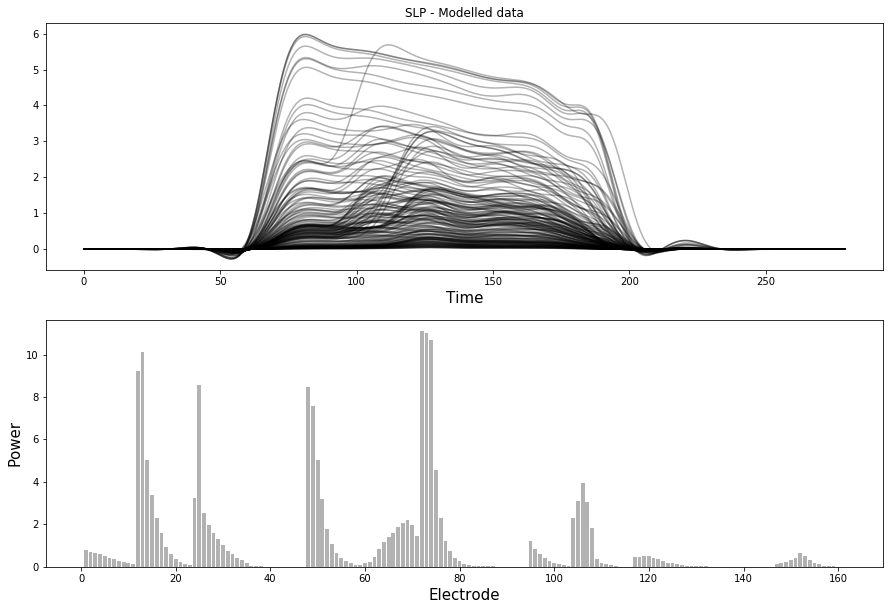

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [8]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]
syn_data = np.load(os.path.join(data_dir, 'syn_tvb_ez=48-79_pz=11-17-22-75.npz'))
x0_mu = syn_data['x0']

stan_fname = 'vep-snsrfit-ode-nointerp'

x0 = -3.0*np.ones(nn)
ez_hyp = np.array([34, 55]) #np.random.randint(0, nn, 2)
pz_hyp = np.array([8, 15, 42, 65])#np.random.randint(0, nn, 4)
print(ez_hyp, 'ground truth:', syn_data['ez'])
print(pz_hyp, 'ground truth:', syn_data['pz'])
x0[ez_hyp] = -1.8
x0[pz_hyp] = -2.3
amplitude = 1.0
offset = 0
K = 1.0
tau0 = 20
eps_slp = 1.0
eps_snsr_pwr = 1.0
x_init = -2.0*np.ones(nn)
z_init = 3.5*np.ones(nn)

param_init = {'x0':x0, 'amplitude':amplitude,
              'offset':offset, 'K':K, 'tau0':tau0, 'x_init':x_init, 'z_init':z_init,
              'eps_slp':eps_slp, 'eps_snsr_pwr':eps_snsr_pwr}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R', param_init)

fname_suffix = f'syn_optim'

data = {'nn':nn, 'ns':ns, 'nt':nt, 'SC':SC, 'gain': gain_mat,
        'slp':slp_ds, 'snsr_pwr':snsr_pwr, 'x0_mu':x0_mu}
input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

[34 55] ground truth: [48 79]
[ 8 15 42 65] ground truth: [11 17 22 75]


In [9]:
%%bash -s "$stan_fname"
stancompile.sh $1
# /home/anirudhnihalani/scripts/stancompile.sh $1


--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp.stan --o=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp.hpp
Model name=vep_snsrfit_ode_nointerp_model
Input file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp.stan
Output file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-nointerp

DIAGNOSTIC(S) FROM PARSER:



In [10]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4

#tol_obj=0 tol_rel_obj=0 tol_grad=0 tol_rel_grad=0 tol_param=0
for i in {1..2};
do
./${STAN_FNAME} optimize algorithm=lbfgs tol_param=1e-10 iter=20000 save_iterations=0  \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [ ]:
print(np.argsort(pstr_samples_1['x0'].mean(axis=0)))
# pstr_samples_1['x0'].shape
print(ez,pz)
# print(pstr_samples_1['time_step'].mean(axis=0))

In [ ]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:nn+1], x0_mu)
plt.xticks(np.r_[1:nn+1:2]);

#### Plots for each chain separately

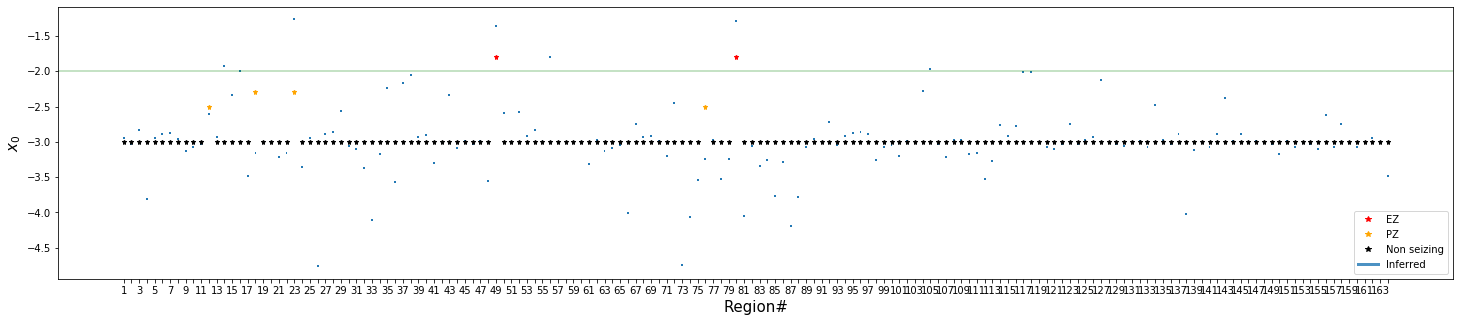

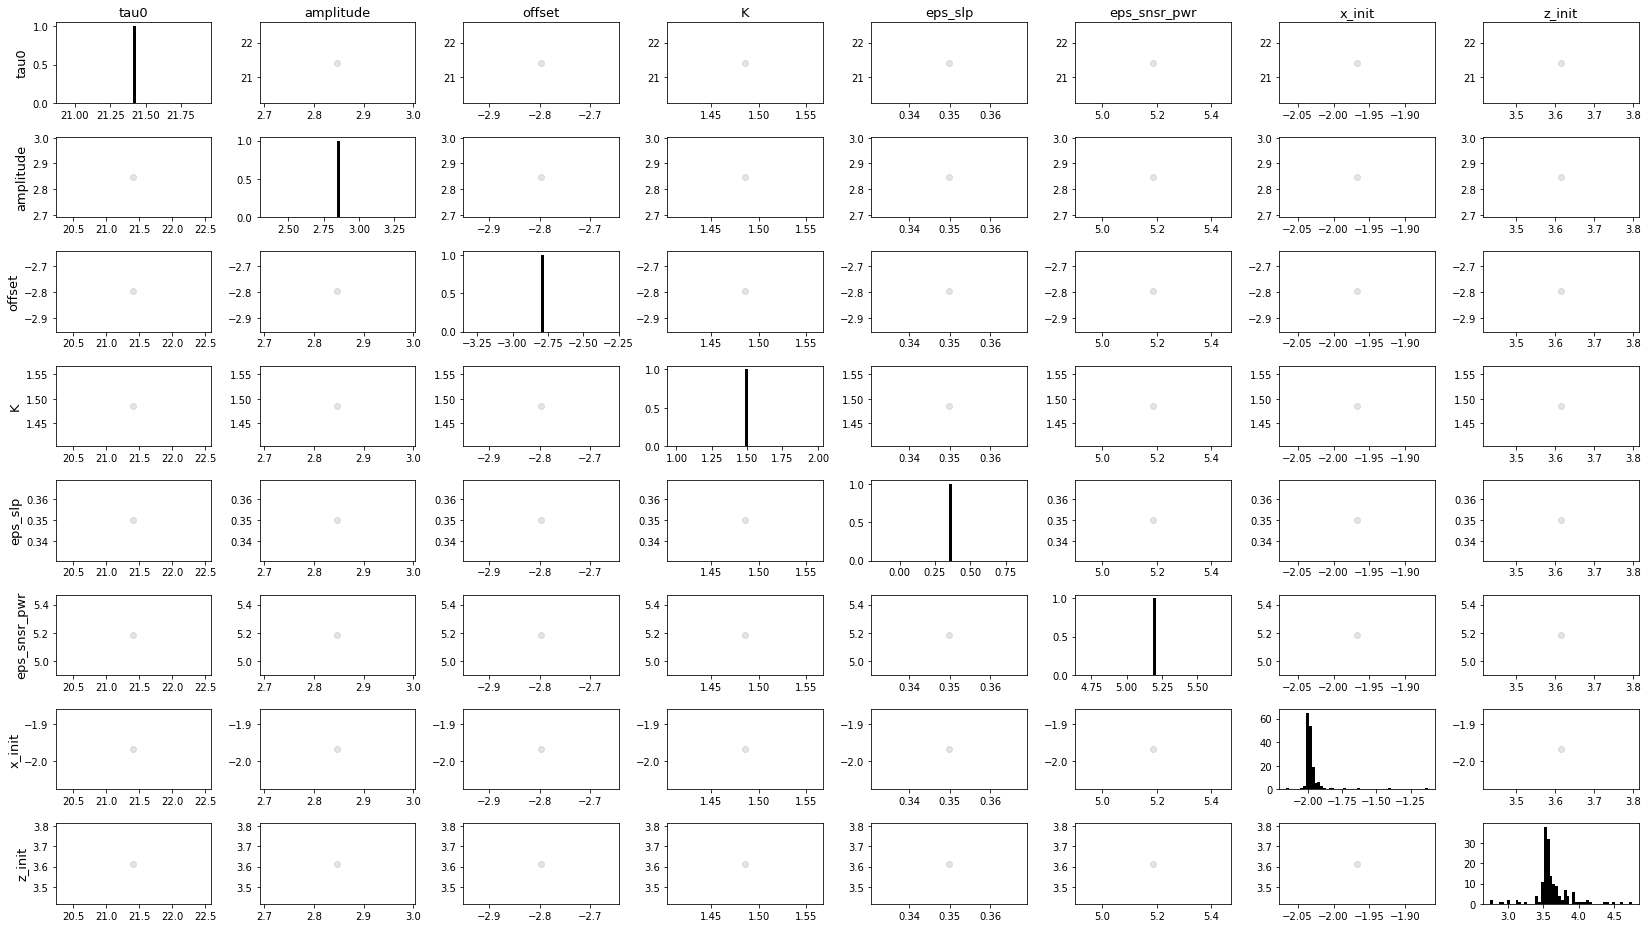

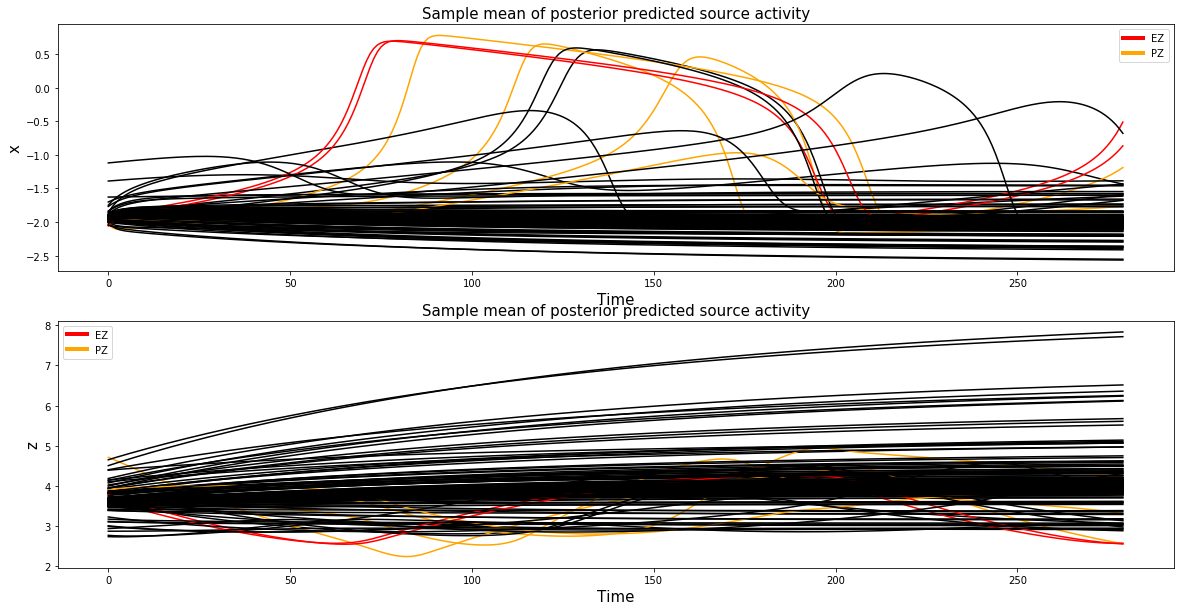

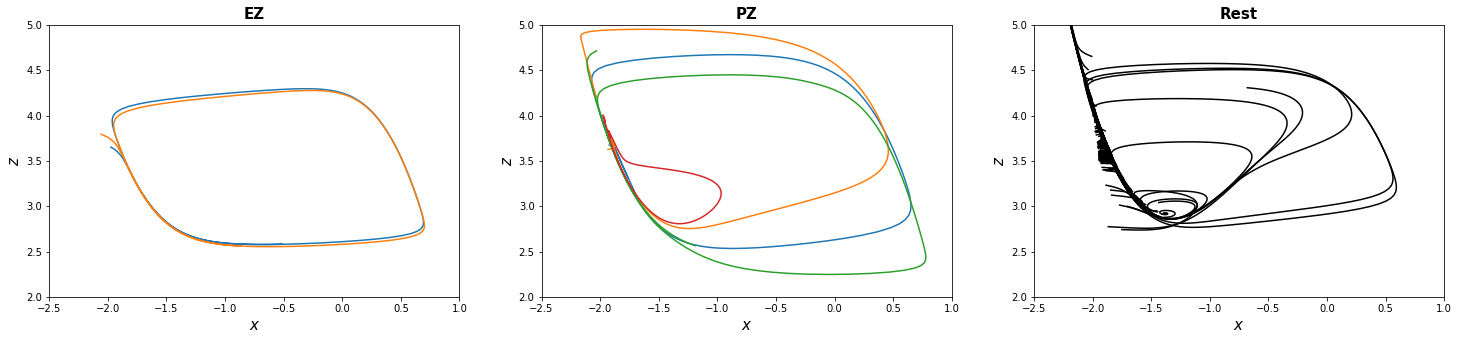

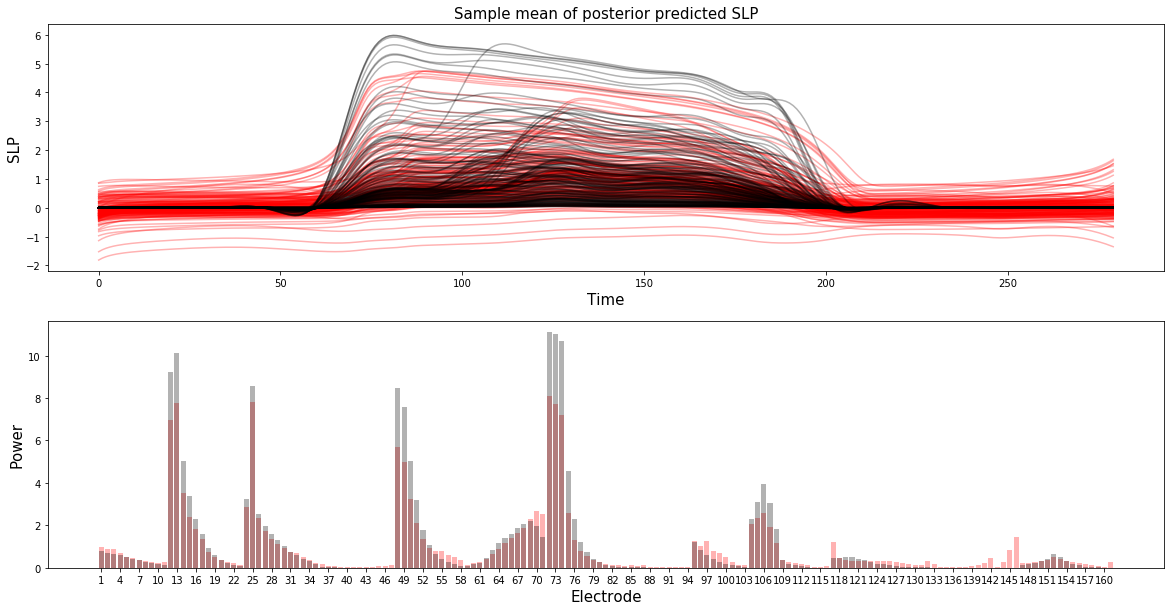

In [11]:
# importlib.reload(lib.plots.stan)
syn_data = np.load('datasets/syn_data/id001_bt/syn_tvb_ez=48-79_pz=11-17-22-75.npz')
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
x0_true = syn_data['x0']
ez = syn_data['ez']
# pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))
pz = syn_data['pz']
szng_roi = np.setxor1d(ez, pz)
non_szng_roi = np.setdiff1d(np.r_[0:nn], szng_roi)

chains = [1]
params = ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr','x_init', 'z_init']
for chain_no in chains:
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
    lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5),
                                 figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png',
                                 legend_loc='lower right')
    lib.plots.stan.pair_plots(samples=pstr_samples, params=params, 
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
    
    x_pp_mean = np.mean(pstr_samples['x'], axis=0)
    z_pp_mean = np.mean(pstr_samples['z'], axis=0)
    lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz,
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_phase(x_pp_mean, z_pp_mean, ez, pz, non_szng_roi,
                              figname=f'{results_dir}/figures/posterior_predicted_phase_plot_{fname_suffix}_chain{chain_no}.png')

    slp = pstr_samples['mu_slp'].mean(axis=0)
    snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
    lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
                               figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')

In [ ]:
for var in pstr_samples.keys():
   pstr_samples[var] = pstr_samples[var][-10:]
lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5),
                             legend_loc='lower right')
lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10))
lib.plots.stan.pair_plots(samples=pstr_samples, params=params, 
                          sampler='HMC')

x_pp_mean = np.mean(pstr_samples['x'], axis=0)
z_pp_mean = np.mean(pstr_samples['z'], axis=0)
lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz)
lib.plots.stan.plot_phase(x_pp_mean, z_pp_mean, ez, pz, non_szng_roi)

slp = pstr_samples['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']})

#### Plots with samples from all chains merged

In [ ]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in chains],
                                      variables_of_interest=variables_of_interest, nwarmup=nwarmup, nsampling=nsampling)

lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')
lib.plots.stan.pair_plots(pstr_samples, params)

x_pp_mean = np.mean(pstr_samples['x'], axis=0)
z_pp_mean = np.mean(pstr_samples['z'], axis=0)
lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz, f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')

slp = pstr_samples['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']},
                               figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')

